In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import warnings 
warnings.filterwarnings("ignore") #ignore some matplotlib warnings

import numpy as np

from triqs.plot.mpl_interface import plt, oplot, oplotr, oploti
plt.rcParams["figure.figsize"] = (6,5) # set default size for all figures

# Bethe-Salpeter Equation (BSE) on the Hubbard atom

To show how `TPRF` can be used to solve Bethe-Salpeter equations we will study the simple case of the Hubbard atom, whose Hamiltonian has the form

$$
H = U n_{\uparrow} n_{\downarrow} .
$$

For this simple system all two particle quantities, the bare susceptibility $\chi_0$, the susceptibility $\chi$, and the particle-hole vertex $\Gamma$ are known analytically (https://arxiv.org/abs/1805.00989). Here we will only solve these equation in the (scalar) magnetic channel of the spin.

However, note that the analytic Hubbard atom functions for the single-particle Green's function and two-particle susceptibility can be replaced with `triqs/cthyb` and a general (retared) impurity problem.

First we setup some system parameters and analytic expressions for the static susceptibility.

In [2]:
U = 1.0
beta = 10.0
nw = 2 # number of bosonic frequencies
nwf = 20 # number of fermionic frequencies
nwf_gf = 2 * nwf # number frequencies for the single particle gf

Z = 2. + 2*np.exp(-beta * 0.5 * U)
m2 = 0.25 * (2 / Z)
chi_m_static = 2. * beta * m2

## Single-particle Green's function $G_{\sigma \sigma'}(i\omega_n)$
To construct the bare suceptibility we need the single particle Green's function $G_{\sigma \sigma'}(i\omega_n)$. While this is diagonal in spin $\sigma \in \{ \uparrow, \downarrow \}$, we first get the diagonal component and then populate a block Green's function with the diagonal elements.

Since the two-particle calculations are done in "full" orbital space we then map the block Green's function to a $2 \times 2$ matrix valued Green's function, as one would have to do for, e.g., a `cthyb` calculation with diagonal hybridization function.

In [3]:
from triqs_tprf.hubbard_atom import single_particle_greens_function
g_iw = single_particle_greens_function(beta=beta, U=U, nw=nwf_gf)

# make block gf of the scalar gf
from triqs.gf import BlockGf, Idx
from triqs_tprf.freq_conv import block_iw_AB_to_matrix_valued
G_iw_block = BlockGf(name_list=['up', 'dn'], block_list=[g_iw, g_iw])
G_iw = block_iw_AB_to_matrix_valued(G_iw_block)

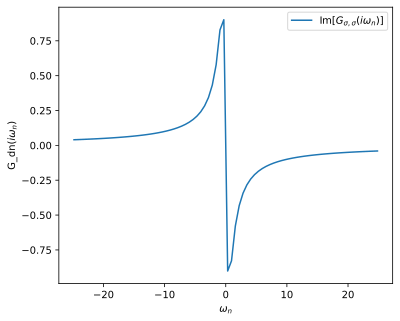

In [4]:
oploti(g_iw, label=r'Im[$G_{\sigma,\sigma}(i\omega_n)$]')

## Bare and full susceptibility $\chi_0$ and $\chi$

The full susceptibility $\chi$ is known analytically (or obtained from an impurity solver through the two-particle Green's function)

In [5]:
from triqs_tprf.hubbard_atom import chi_ph_magnetic
chi_m = chi_ph_magnetic(beta=beta, U=U, nw=nw, nwf=nwf)

The bare susceptbilitiy $\chi_0$ is constructed from the matrix valued single-particle Green's function $G_{\sigma\sigma'}(i\omega_n)$, we also pass $\chi$ in order to construct $\chi_0$ with the same mesh size.

In [6]:
from triqs_tprf.chi_from_gg2 import chi0_from_gg2_PH
chi0_m = chi0_from_gg2_PH(G_iw, chi_m)

Now we can plot $\chi_0$ and $\chi$

In [7]:
def plot_chi(chi, label='', opt={}):
    data = chi[Idx(1), :, :][0, 0, 0, 0].data

    plt.figure(figsize=(3.25*2, 3))
    subp = [1, 2, 1]
    
    def plot_data(data, subp, label=None, opt={}):
        plt.subplot(*subp); subp[-1] += 1
        plt.imshow( data, **opt )
        plt.title(label); plt.colorbar(); plt.axis('equal');

    plot_data(data.real, subp, label='Re[%s]' % label)
    plot_data(data.imag, subp, label='Im[%s]' % label)
    plt.tight_layout()

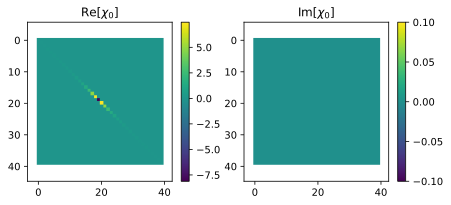

In [8]:
plot_chi(chi0_m, label=r'$\chi_0$')

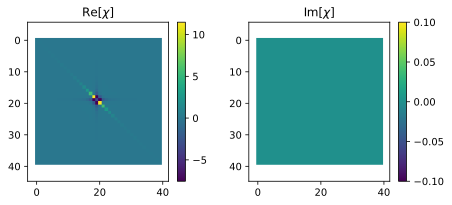

In [9]:
plot_chi(chi_m, label=r'$\chi$')

## Bethe-Salpeter Equation (BSE) for $\Gamma_m^{(PH)}$

The particle-hole vertex can (approximately) be obtained by inverting the Bethe-Salpeter equation (BSE)

$$
\Gamma = \chi_0^{-1} - \chi^{-1}
$$

Here each object has three frequency dependence $\chi \equiv \chi(\omega, \nu, \nu')$. 

Note that the equation is a matrix equation in the two fermionic frequencies $\nu$ and $\nu'$, whence the BSE is in principle an infinite matrix equation. Here we truncate this frequency in a **finite** frequency window, which is an approximation.

In [10]:
from triqs_tprf.linalg import inverse_PH
gamma_m = inverse_PH(chi0_m) - inverse_PH(chi_m)

We can now plot the vertex that mainly has diagonal features

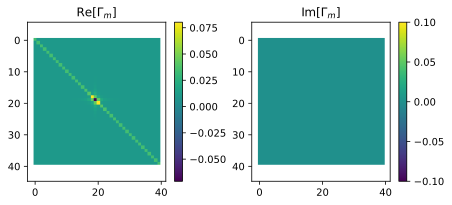

In [11]:
plot_chi(gamma_m, label=r'$\Gamma_m$', opt={})

## Analytic vertex $\Gamma_m^{(PH)}$

The vertex is known analytically for the Hubbard atom, so we can compare the result from the BSE calculation. (The deviations comes from the finite frequency window.)

In [12]:
from triqs_tprf.hubbard_atom import gamma_ph_magnetic
gamma_m_anal = gamma_ph_magnetic(beta=beta, U=U, nw=nw, nwf=nwf)

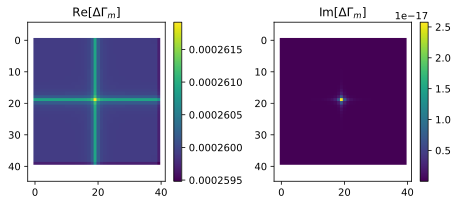

In [13]:
plot_chi(gamma_m - gamma_m_anal, label=r'$\Delta \Gamma_m$')

## BSE frequency window convergence

The helper function `triqs_tprf.analytic_hubbard_atom.analytic_hubbard_atom` performes the steps above for the Hubbard atom and returns an object with the collected result.

With this we can study the convergence of the vertex $\Gamma$ computed with the Bethe-Salpeter equation with respect to the fermionic frequency window size `nwf`.

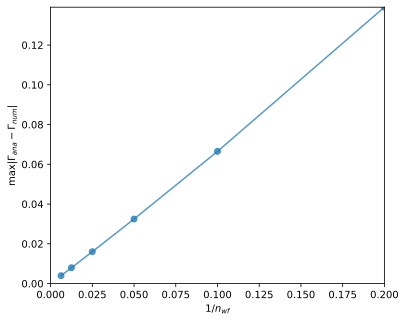

In [14]:
from triqs_tprf.analytic_hubbard_atom import analytic_hubbard_atom

nwf_vec = np.array([5, 10, 20, 40, 80, 160])
diff_vec = np.zeros_like(nwf_vec, dtype=np.float)

for idx, nwf in enumerate(nwf_vec):
     d = analytic_hubbard_atom(beta=2.0, U=5.0, nw=1, nwf=nwf, nwf_gf=2*nwf)
     diff_vec[idx] = np.max(np.abs( d.gamma_m.data - d.gamma_m_num.data ))

x = 1./nwf_vec
plt.plot(x, diff_vec, 'o-', alpha=0.75)
plt.xlabel(r'$1/n_{wf}$')
plt.ylabel(r'$\max|\Gamma_{ana} - \Gamma_{num}|$')
plt.ylim([0, diff_vec.max()]); plt.xlim([0, x.max()]);

To improve on this linear convergence requires a better representation of the two-particle objects and a different approach to the Bethe-Salpeter equation.